In [76]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy.stats import pearsonr
from scipy.optimize import differential_evolution
from skopt import gp_minimize


In [77]:
prices_df = pd.read_csv('data/commercial_variables.csv')
a_and_p_df = pd.read_csv('data/a&p_variables.csv')
a_and_p_definition_df = pd.read_csv('data/a&p_variables_definition.csv')
kpi_definition_df = pd.read_csv('data/kpi_&_com_variables_definition.csv')
kpi_model_df = pd.read_csv('data/kpi_to_model.csv')
merged_df = pd.read_csv('data/merged_data.csv')


In [78]:
kpi_model_df.drop('Year', axis=1, inplace=True)
kpi_model_df.set_index('Starting Week', inplace=True)

In [79]:
fig = go.Figure()

# Add traces for each column
for col in kpi_model_df.columns:
    fig.add_trace(go.Scatter(y=kpi_model_df[col], x=kpi_model_df.index, mode='lines', name=col))

# Customize layout
fig.update_layout(
    title="Online and Offline Sellout Value and Units",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Columns",
)

# Show figure
fig.show()


Easier to model the sales units rather than value

In [80]:
sellout_units_df = kpi_model_df.iloc[:,[1,3]]

In [81]:
fig = go.Figure()

# Add traces for each column
for col in sellout_units_df.columns:
    fig.add_trace(go.Scatter(y=sellout_units_df[col], x=sellout_units_df.index, mode='lines', name=col))

# Customize layout
fig.update_layout(
    title="Online and Offline Sellout Units",
    xaxis_title="Date",
    yaxis_title="Value",
    legend_title="Columns",
)

# Show figure
fig.show()


Building a model for OOH sales 

In [82]:
# Isolate OOH sales units
OOH_units = sellout_units_df.iloc[:,0]

# Align the features
OOH_frame = a_and_p_df.set_index('Starting week')
OOH_frame['Sales_Units'] = OOH_units

# Now take in the commercial price related data 
prices_df.drop('Year', axis=1, inplace=True)
prices_df.set_index('Starting Week', inplace=True)

OOH_frame = pd.merge(left=OOH_frame, right=prices_df, how='left', left_index=True, right_index=True)


Make some forward lags of sales units

In [83]:
OOH_frame.rename(columns={'Sales_Units':'Sales_Units_t'}, inplace=True)

# Assuming OOH_frame is your DataFrame
OOH_frame['Sales_Units_t+1'] = OOH_frame['Sales_Units_t'].shift(-1)  # Forward lag of 1
OOH_frame['Sales_Units_t+2'] = OOH_frame['Sales_Units_t'].shift(-2)  # Forward lag of 2
OOH_frame['Sales_Units_t+3'] = OOH_frame['Sales_Units_t'].shift(-3)  # Forward lag of 3


Interesting to look at the offline discount to online

In [84]:
Offline_Avg_price = OOH_frame.iloc[:,9]  # Easier than specifying the full name
Online_Avg_price = OOH_frame.iloc[:,10]

OOH_frame['Offline_Discount_t'] = ((Offline_Avg_price - Online_Avg_price) / (Offline_Avg_price)) * 100

col_names = list(OOH_frame.columns)
OOH_frame.drop(col_names[10], axis=1, inplace=True)
# Rename the column to something more manageable 
OOH_frame.rename(columns={col_names[9]: 'Offline_Avg_Price', col_names[11]: 'Weighted_Promotion_Distribution'},inplace=True)  



Also compute some forward lags on the offline discount 

In [85]:
OOH_frame['Offline_Discount_t+1'] = OOH_frame['Offline_Discount_t'].shift(-1)  # Forward lag of 1
OOH_frame['Offline_Discount_t+2'] = OOH_frame['Offline_Discount_t'].shift(-2)  # Forward lag of 2
OOH_frame['Offline_Discount_t+3'] = OOH_frame['Offline_Discount_t'].shift(-3)  # Forward lag of 3

Drop the level 1 distinction - its constant

In [86]:
print(OOH_frame['growth_driver_l1'].unique())

# We drop it 
OOH_frame.drop('growth_driver_l1', axis=1, inplace=True)


['ap_consumer_facing']


In [87]:
OOH_frame

,growth_driver_l2,growth_driver_l3,growth_driver_l4,growth_driver_l5,metric,investment (in pound),execution,Sales_Units_t,Offline_Avg_Price,Weighted_Promotion_Distribution,Sales_Units_t+1,Sales_Units_t+2,Sales_Units_t+3,Offline_Discount_t,Offline_Discount_t+1,Offline_Discount_t+2,Offline_Discount_t+3
Starting week,,,,,,,,,,,,,,,,,
2022-01-03,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,107.438017,537.216943,681362.5,2.323822,0.37,753049.7,710890.7,729487.2,-39.514642,-27.920478,-26.731924,-28.386212
2022-01-10,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,0.000000,0.000000,753049.7,2.328649,0.42,710890.7,729487.2,738346.7,-27.920478,-26.731924,-28.386212,-38.071158
2022-01-17,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,0.000000,0.000000,710890.7,2.378280,0.43,729487.2,738346.7,721747.0,-26.731924,-28.386212,-38.071158,-31.605457
2022-01-24,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,28484.999998,142432.121596,729487.2,2.396989,0.86,738346.7,721747.0,687971.7,-28.386212,-38.071158,-31.605457,-28.992541
2022-01-31,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,19172.915190,95869.369418,738346.7,2.394615,0.78,721747.0,687971.7,686506.6,-38.071158,-31.605457,-28.992541,-26.102886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,shopper_experience,shopper_experience,testers_and_merchandising,testers_and_merchandising,units,0.000000,0.000000,806178.1,3.067400,0.91,810641.0,878861.1,1069429.4,-22.957313,-24.503542,-25.498482,-23.993277
2023-12-04,shopper_experience,shopper_experience,testers_and_merchandising,testers_and_merchandising,units,0.000000,0.000000,810641.0,3.039699,0.81,878861.1,1069429.4,606425.3,-24.503542,-25.498482,-23.993277,-43.629705
2023-12-11,shopper_experience,shopper_experience,testers_and_merchandising,testers_and_merchandising,units,3381.443000,193.700000,878861.1,3.057034,0.81,1069429.4,606425.3,NaN,-25.498482,-23.993277,-43.629705,NaN


In [88]:
OOH_frame.head()

,growth_driver_l2,growth_driver_l3,growth_driver_l4,growth_driver_l5,metric,investment (in pound),execution,Sales_Units_t,Offline_Avg_Price,Weighted_Promotion_Distribution,Sales_Units_t+1,Sales_Units_t+2,Sales_Units_t+3,Offline_Discount_t,Offline_Discount_t+1,Offline_Discount_t+2,Offline_Discount_t+3
Starting week,,,,,,,,,,,,,,,,,
2022-01-03,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,107.438017,537.216943,681362.5,2.323822,0.37,753049.7,710890.7,729487.2,-39.514642,-27.920478,-26.731924,-28.386212
2022-01-10,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,0.000000,0.000000,753049.7,2.328649,0.42,710890.7,729487.2,738346.7,-27.920478,-26.731924,-28.386212,-38.071158
2022-01-17,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,0.000000,0.000000,710890.7,2.378280,0.43,729487.2,738346.7,721747.0,-26.731924,-28.386212,-38.071158,-31.605457
2022-01-24,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,28484.999998,142432.121596,729487.2,2.396989,0.86,738346.7,721747.0,687971.7,-28.386212,-38.071158,-31.605457,-28.992541
2022-01-31,consumer_engagement,advocacy_media,influencer_management,influencer_management,engagements,19172.915190,95869.369418,738346.7,2.394615,0.78,721747.0,687971.7,686506.6,-38.071158,-31.605457,-28.992541,-26.102886


In [89]:
OOH_frame['growth_driver_l5'].unique()

array(['influencer_management', 'bvod', 'amazon_retail', 'tesco',
       'google_video', 'youtube', 'google', 'amazon', 'citrus', 'criteo',
       'meta', 'pinterest', 'tik_tok', 'meta_collab_ads', 'the_hut_group',
       'linear', 'testers_and_merchandising'], dtype=object)

In [90]:
OOH_frame['metric'].unique()

array(['engagements', 'impressions', 'grps', 'units'], dtype=object)

In [91]:
OOH_frame['growth_driver_l4'].unique()

array(['influencer_management', 'digital_tv',
       'online_multiformat_ads_transaction',
       'online_video_content_platforms',
       'paid_search_awarenessconsideration', 'paid_search_transaction',
       'social_media_awarenessconsideration', 'social_media_transaction',
       'traditional_tv', 'testers_and_merchandising'], dtype=object)

In [92]:
l5_levers = OOH_frame['growth_driver_l5'].unique()
l4_levers = OOH_frame['growth_driver_l4'].unique()

print('Number of l5 levers', len(l5_levers))
print('l5_levers:', l5_levers)

print()

print('Number of l4 levers', len(l4_levers))
print('l4 levers:', l4_levers)

Number of l5 levers 17
l5_levers: ['influencer_management' 'bvod' 'amazon_retail' 'tesco' 'google_video'
 'youtube' 'google' 'amazon' 'citrus' 'criteo' 'meta' 'pinterest'
 'tik_tok' 'meta_collab_ads' 'the_hut_group' 'linear'
 'testers_and_merchandising']

Number of l4 levers 10
l4 levers: ['influencer_management' 'digital_tv' 'online_multiformat_ads_transaction'
 'online_video_content_platforms' 'paid_search_awarenessconsideration'
 'paid_search_transaction' 'social_media_awarenessconsideration'
 'social_media_transaction' 'traditional_tv' 'testers_and_merchandising']


Encode at the l4 level and make a modelling df

In [93]:
OOH_frame_cols = OOH_frame.columns
#indices_to_drop = [0, 1, 3]
indices_to_drop = [0, 1, 2]  # for l5
names = [OOH_frame_cols[x] for x in indices_to_drop]
Modelling_l4_df = OOH_frame.drop(columns=names, axis=1)

In [94]:
Modelling_l4_df.columns

Index(['growth_driver_l5', 'metric', 'investment (in pound)', 'execution',
       'Sales_Units_t', 'Offline_Avg_Price', 'Weighted_Promotion_Distribution',
       'Sales_Units_t+1', 'Sales_Units_t+2', 'Sales_Units_t+3',
       'Offline_Discount_t', 'Offline_Discount_t+1', 'Offline_Discount_t+2',
       'Offline_Discount_t+3'],
      dtype='object')

In [95]:
def create_lever_usage_plot(df):
    # Create a pivot table to reshape the data
    pivot_df = pd.pivot_table(
        df,
        values='investment (in pound)',
        index=df.index,  # This is your date
        #columns='growth_driver_l4',
        columns='growth_driver_l5',
        fill_value=0
    )
    
    # Create a stacked bar plot
    fig, ax = plt.subplots(figsize=(80, 45))  # Increase figure size
    pivot_df.plot(kind='bar', stacked=True, ax=ax)

    # Formatting
    plt.title('execution', fontsize=120)
    plt.xlabel('Date', fontsize=80)
    plt.ylabel('Execution Amount', fontsize=80)
    plt.legend(title='Marketing Levers', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=60)
    
    # Adjust x-tick labels to prevent overlap
    xticks = range(0, len(pivot_df), max(1, len(pivot_df) // 20))  # Reduce number of x-ticks
    plt.xticks(xticks, pivot_df.index[xticks], rotation=30, ha='right', fontsize=35)

    plt.yticks(fontsize=40)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return plt

# This creates a monthly look at the a and p levers 
def create_lever_heatmap(df):
    # Ensure index is in datetime format
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Create a pivot table
    pivot_df = pd.pivot_table(
        df,
        values='execution',
        index=pd.Grouper(freq='ME'),  
        #columns='growth_driver_l4',
        columns='growth_driver_l5',
        fill_value=0
    )
    
    # Create heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_df, cmap='YlOrRd', annot=True, fmt='.0f')

    plt.title('Marketing Lever Usage Intensity Over Time')
    plt.xlabel('Marketing Levers')
    plt.ylabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt


<module 'matplotlib.pyplot' from 'c:\\Users\\35387\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

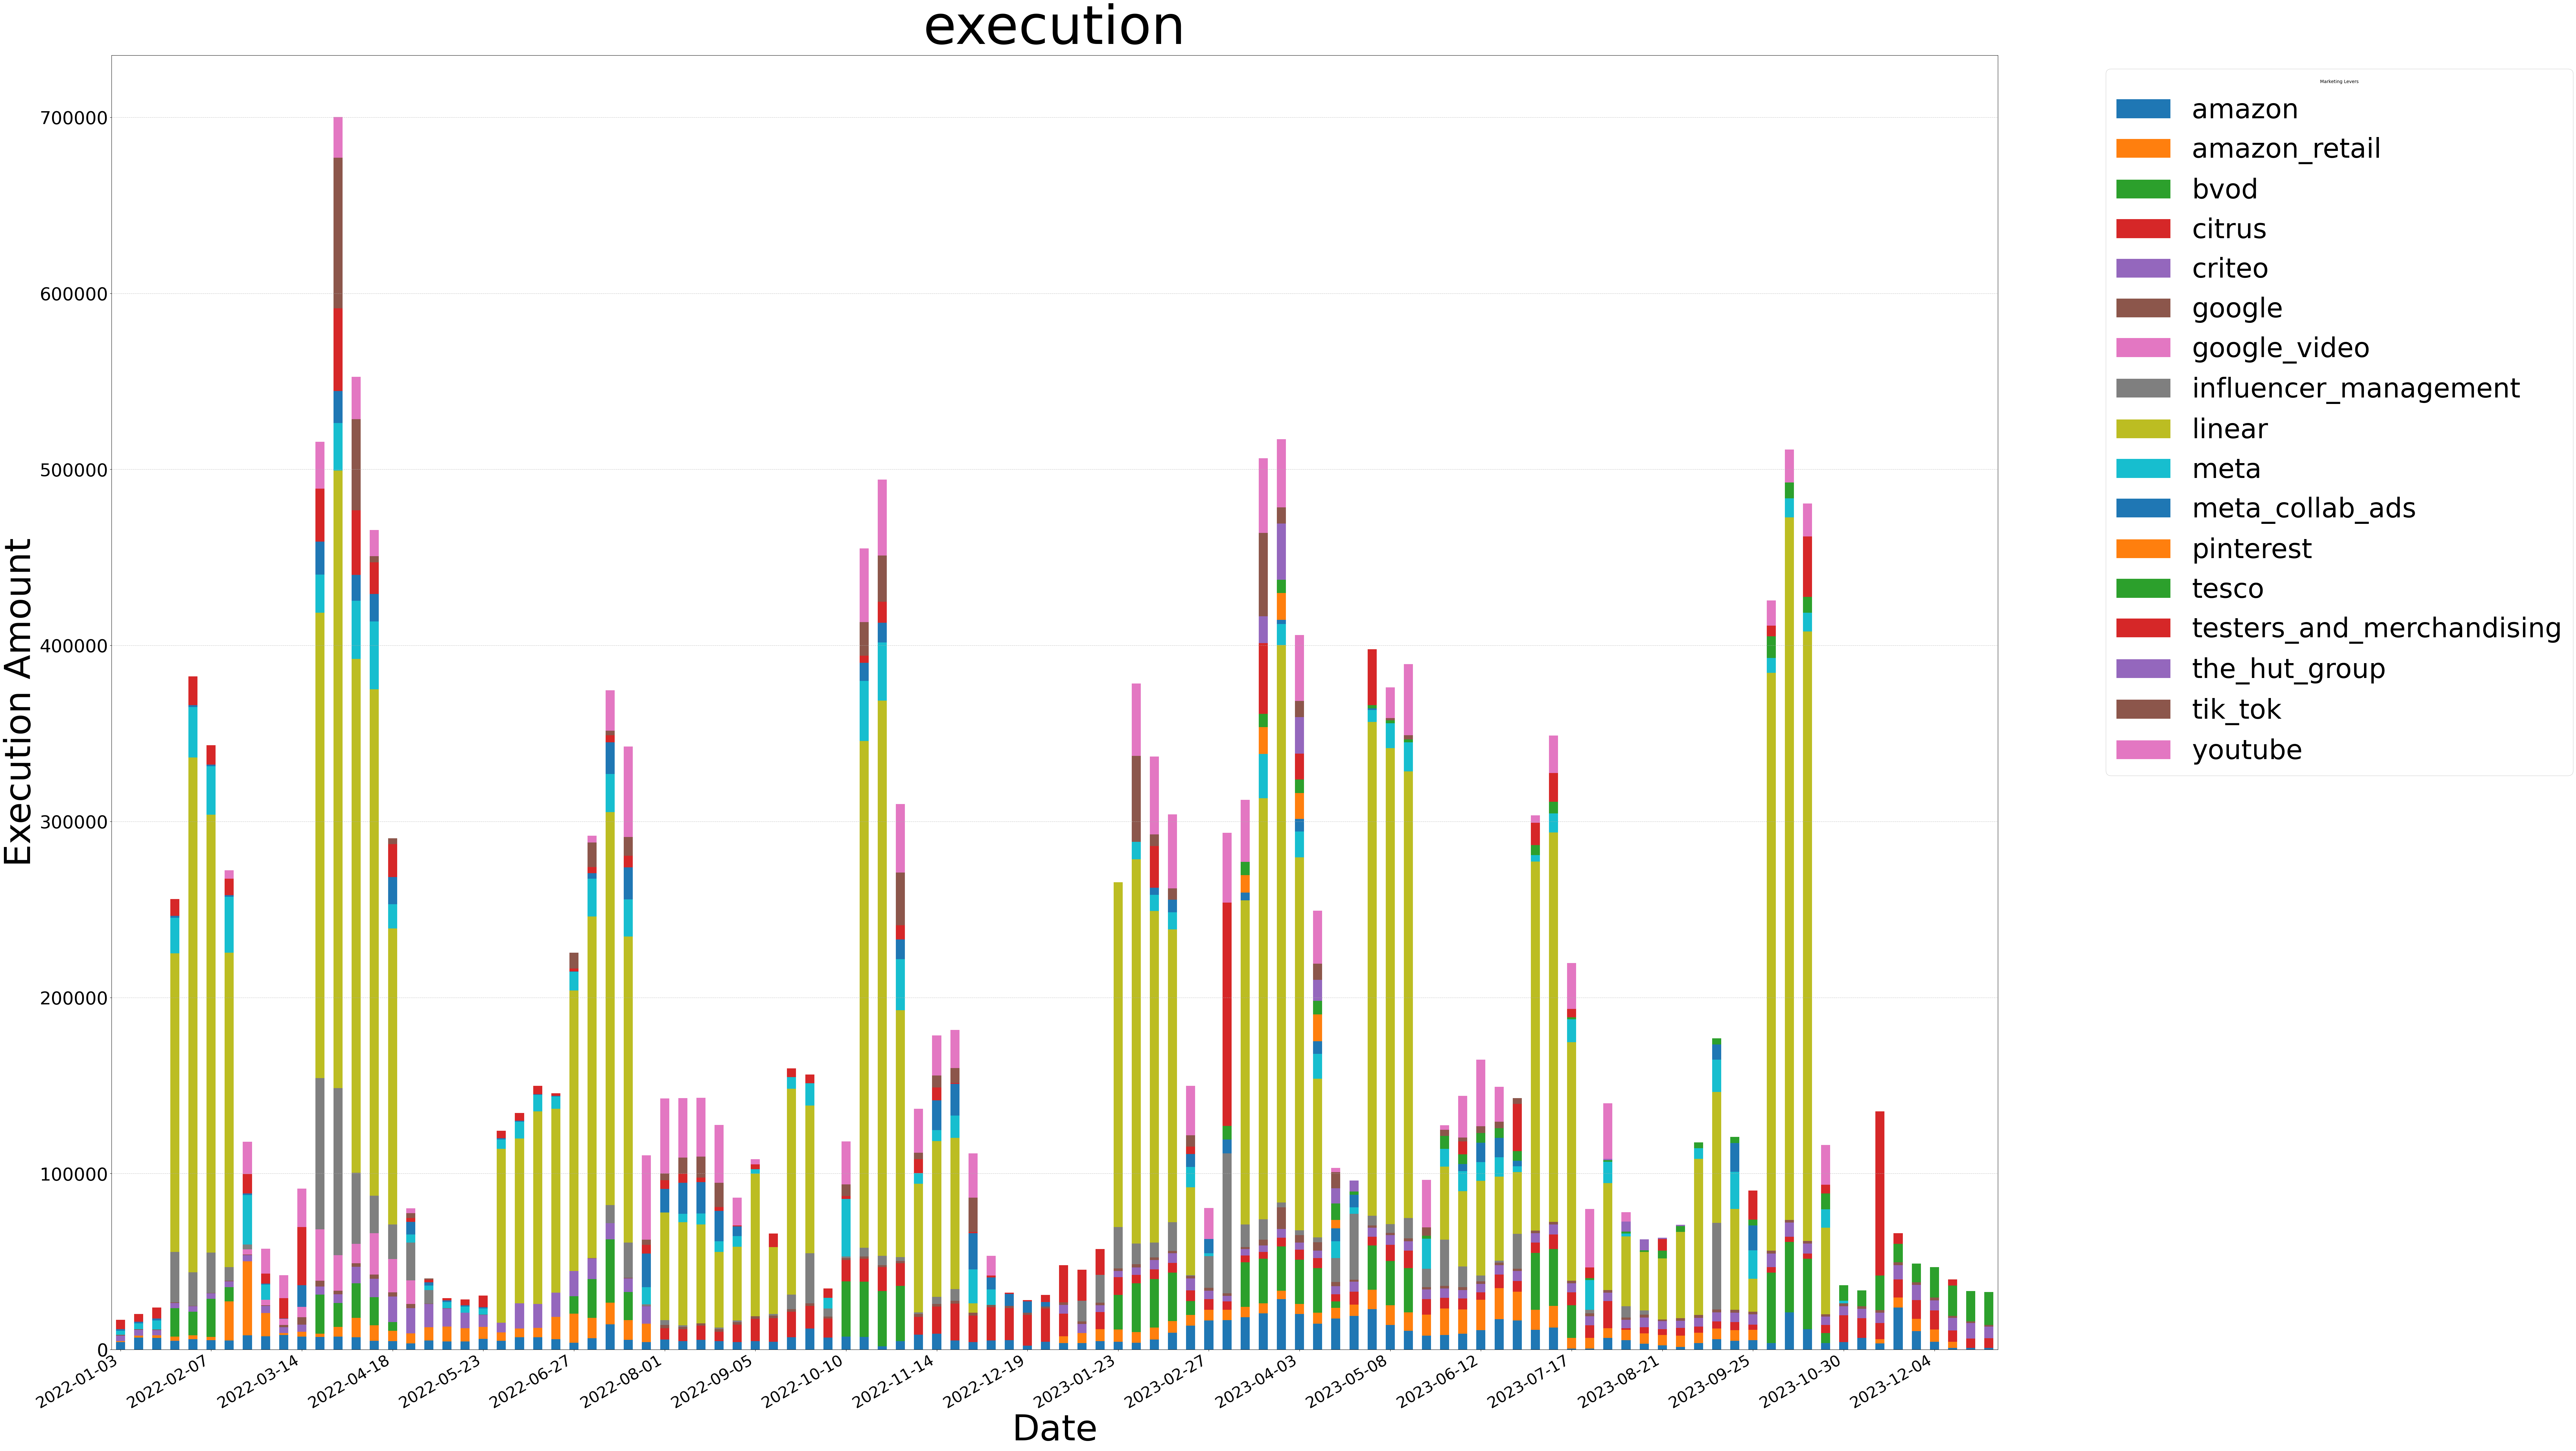

In [96]:
create_lever_usage_plot(Modelling_l4_df)